In [74]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import warnings

In [75]:
#read the experimental data
data = pd.read_csv("data.csv")
display(data)

#Define the time range
t = data.iloc[:,0]

#Define experimental concentration data
Xexp = data.iloc[:,1]
Sexp = data.iloc[:,2]
Pexp = data.iloc[:,3]

,t(h),X,S,P
0,0,1.70,91.45,0.87
1,1,1.65,89.74,1.77
2,2,1.85,87.94,2.03
3,3,2.80,81.84,4.05
4,4,2.65,74.64,8.18
5,5,3.35,65.85,12.80
6,6,3.30,55.23,15.38
7,7,5.05,45.54,21.10
8,8,4.17,37.96,28.06
9,9,3.90,28.66,33.22


In [76]:
def monodP(z,t,paras):
    """_System of equations used to describe the kinetics of fermentation (Monod with inhibition of product)_

    Args:
        z (_): vector
        t (_array_): time
        paras (_dict_): kinetic parameters

    Returns:
        _array_: differencials of X, S, and P over time_
    """
    #Conversion parameters (experimental)
    Yxs = 0.0434
    Yps = 0.5078
    Ypx = Yps/Yxs

    #Assign each variable to a vector z
    X = z[0]
    S = z[1]
    P = z[2]

    #Define the parameters to adjust
    try:
        umax = paras['umax'].value
        Ks   = paras['Ks'].value
        N    = paras['N'].value
        Psat = paras['Psat'].value

    except KeyError:
        umax, Ks, N, Psat = paras

    #Define the ODE system
    dXdt = umax*S/(Ks+S)*X*(1-P/Psat)**N
    dSdt = -umax*S/(Ks+S)*X/Yxs*(1-P/Psat)**N
    dPdt = umax*S/(Ks+S)*X*Ypx*(1-P/Psat)**N
   
    return [dXdt,dSdt,dPdt]

In [77]:
def solver(t,x0,paras):
    """_solve the differential equations from the model_

    Args:
        t (_array_): time
        x0 (_list_): initial values of X, S, and P
        paras (_dict_): kinetic parameters

    Returns:
        _array_: solutions of X, S, and P
    """
    x = odeint(monodP,x0,t,args=(paras,))
    return x

In [78]:
#Define objective function
def objFun(paras,t,Xexp,Sexp,Pexp):
    """_objective function using experimental data from X, S, and P_

    Args:
        paras (_dict_): kinetic parameters
        t (_array_): time
        Xexp (_array_): Experimental yeast concentration
        Sexp (_array_): Experimental substrate concentration
        Pexp (_array_): Experimental ethanol concentration
        
    Returns:
        _array_: result of objective function
    """
    x0 = paras['X0'].value, paras['S0'].value, paras['P0'].value
    model = solver(t,x0,paras)
    X_model = model[:, 0]
    S_model = model[:, 1]
    P_model = model[:, 2]
    return (((X_model-Xexp)**2 + (P_model-Pexp)**2 + (S_model-Sexp)**2)**0.5).ravel()

In [79]:
#Define initial conditions
X0 = data.iloc[0,1]
S0 = data.iloc[0,2]
P0 = data.iloc[0,3]
init = [X0, S0, P0]

#Set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('X0', value=X0, vary=False)
params.add('S0', value=S0, vary=False)
params.add('P0', value=P0, vary=False)
params.add('umax', value=0.5, min=0, max=1)
params.add('Ks', value=0.5, min=0, max=5)
params.add('N', value=1, min=0, max=3)
params.add('Psat', value=103, min=100, max=200)

#Minimize the objective function optimizing "params"
result = minimize(objFun, params, args=(t, Xexp, Sexp, Pexp), method='leastsq')

# results of the optimal fit at experimental time 
fitted = solver(t, init, result.params)
Xopt = fitted[:,0]
Sopt = fitted[:,1]
Popt = fitted[:,2]

# display fitted statistics
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 13
    # variables        = 4
    chi-square         = 170.946701
    reduced chi-square = 18.9940778
    Akaike info crit   = 41.4932320
    Bayesian info crit = 43.7530294
[[Variables]]
    X0:    1.7 (fixed)
    S0:    91.45 (fixed)
    P0:    0.87 (fixed)
    umax:  0.10622003 +/- 0.02045821 (19.26%) (init = 0.5)
    Ks:    0.47960686 +/- 24.7250800 (5155.28%) (init = 0.5)
    N:     1.1030e-10 +/- 3.82808100 (3470463649543.45%) (init = 1)
    Psat:  199.309947 +/- 1.5420e+09 (773656152.12%) (init = 103)
[[Correlations]] (unreported correlations are < 0.100)
    C(Ks, N)      = -0.931
    C(Ks, Psat)   = -0.873
    C(umax, Psat) = -0.868
    C(umax, Ks)   = 0.830
    C(N, Psat)    = 0.700
    C(umax, N)    = -0.573


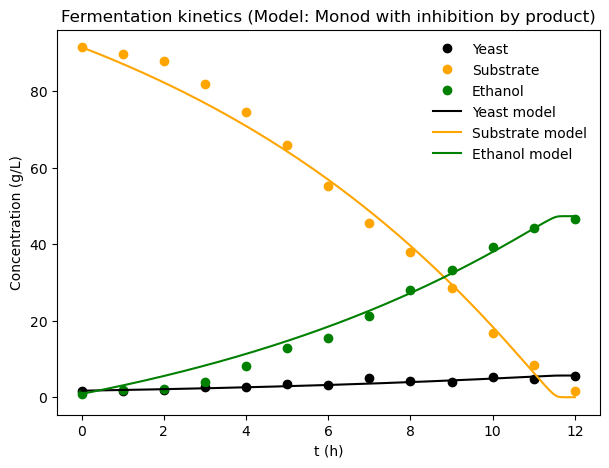

In [80]:
#Graphics
# results of the optimal fit in arbritary time 
t2 = np.linspace(0, max(t),250)
fitted2 = solver(t2, init, result.params)
Xopt2 = fitted2[:,0]
Sopt2 = fitted2[:,1]
Popt2 = fitted2[:,2]

plt.figure(0, figsize=(7, 5))
#Experimental points
plt.plot(t, Xexp, 'o', color='black', label = 'Yeast')
plt.plot(t, Sexp, 'o', color='orange',label = 'Substrate')
plt.plot(t, Pexp, 'o', color='green', label = 'Ethanol')

#ODE system model
plt.plot(t2, Xopt2,'-', color='black', label = 'Yeast model')
plt.plot(t2, Sopt2,'-', color='orange',label = 'Substrate model')
plt.plot(t2, Popt2,'-', color='green', label = 'Ethanol model')

#Graphic parameters
plt.title('Fermentation kinetics (Model: Monod with inhibition by product)')
plt.xlabel('t (h)')
plt.ylabel('Concentration (g/L)')
plt.legend(loc='best', frameon=False)

Text(0.5, 1.0, 'Ethanol')

<Figure size 640x480 with 0 Axes>

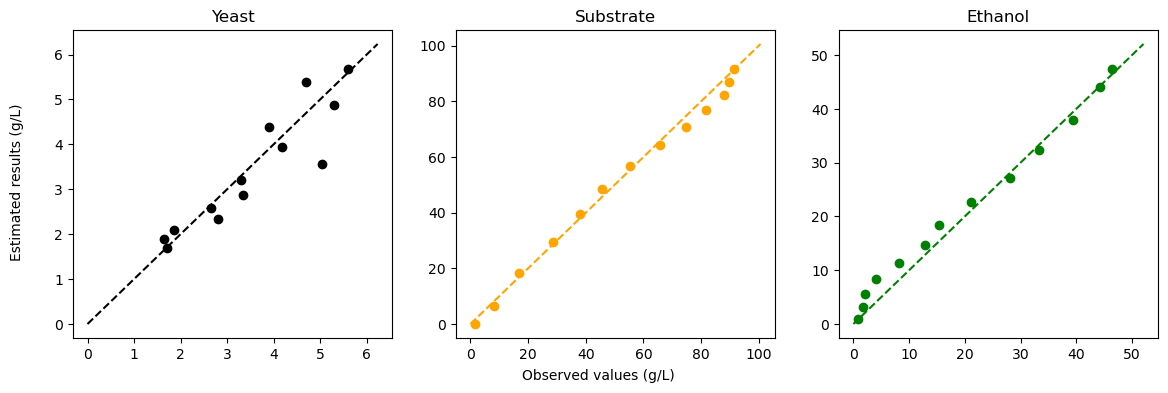

In [81]:
#Estimated vs. observed plots
plt.figure(1)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.text(0.5, 0.005, 'Observed values (g/L)', ha='center')
fig.text(0.08, 0.5, 'Estimated results (g/L)', va='center', rotation='vertical')

axs[0].plot(Xexp, Xopt, 'o', color='black')
axs[0].plot([0,max(Xopt)*1.1], [0,max(Xopt)*1.1], '--', color='black')
axs[0].set_title('Yeast')

axs[1].plot(Sexp, Sopt, 'o', color='orange')
axs[1].plot([0,max(Sopt)*1.1], [0,max(Sopt)*1.1], '--', color='orange')
axs[1].set_title('Substrate')

axs[2].plot(Pexp, Popt, 'o', color='green')
axs[2].plot([0,max(Popt)*1.1], [0,max(Popt)*1.1], '--', color='green')
axs[2].set_title('Ethanol')


In [82]:
#Statistics
print("X: R² = {:.3f}".format(r2_score(Xexp,Xopt)))
print("S: R² = {:.3f}".format(r2_score(Sexp,Sopt)))
print("P: R² = {:.3f}".format(r2_score(Pexp,Popt)))

X: R² = 0.835
S: R² = 0.991
P: R² = 0.982


In [83]:
#Specify the confidence level
alfa = 0.05

#Calculate the residues and test normality
resX = Xexp - Xopt
hX = stats.shapiro(resX)
if hX[1] < alfa:
    print('The residues of X are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hX[1],alfa))
else:
    print('The residues of X are normally distributed. p-value = {:.3f} > {:.2f}'.format(hX[1],alfa))

resS = Sexp - Sopt
hS = stats.shapiro(resS)
if hS[1] < alfa:
    print('The residues of S are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hS[1],alfa))
else:
    print('The residues of S are normally distributed. p-value = {:.3f} > {:.2f}'.format(hS[1],alfa))

resP = Pexp - Popt
hP = stats.shapiro(resP)
if hP[1] < alfa:
    print('The residues of P are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hP[1],alfa))
else:
    print('The residues of P are normally distributed. p-value = {:.3f} > {:.2f}'.format(hP[1],alfa))


The residues of X are normally distributed. p-value = 0.233 > 0.05
The residues of S are normally distributed. p-value = 0.598 > 0.05
The residues of P are normally distributed. p-value = 0.513 > 0.05


Text(0, 0.5, '')

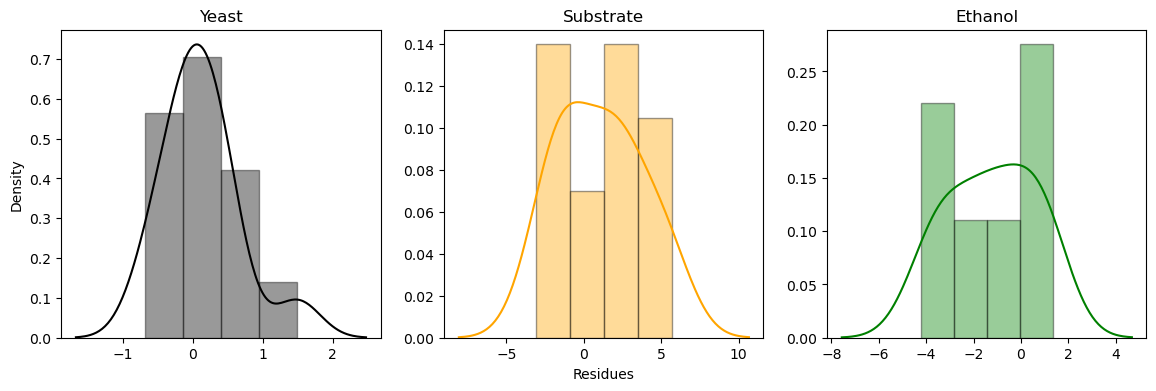

In [84]:
#Histogram residues
warnings.filterwarnings('ignore')
f = plt.figure(2, figsize=(14,4))

f.add_subplot(1,3,1)
sns.distplot(resX, hist = True, kde = True, bins = 4, color = 'black', hist_kws={'edgecolor': 'black'})
plt.title("Yeast")
plt.xlabel("") 
plt.ylabel("Density") 

f.add_subplot(1,3,2)
sns.distplot(resS, hist = True, kde = True, bins = 4, color = 'orange', hist_kws={'edgecolor': 'black'})
plt.title("Substrate")
plt.xlabel("Residues") 
plt.ylabel("")

f.add_subplot(1,3,3)
sns.distplot(resP, hist = True, kde = True, bins = 4, color = 'green', hist_kws={'edgecolor': 'black'})
plt.title("Ethanol")
plt.xlabel("") 
plt.ylabel("")

Text(0.5, 1.0, 'Ethanol')

<Figure size 640x480 with 0 Axes>

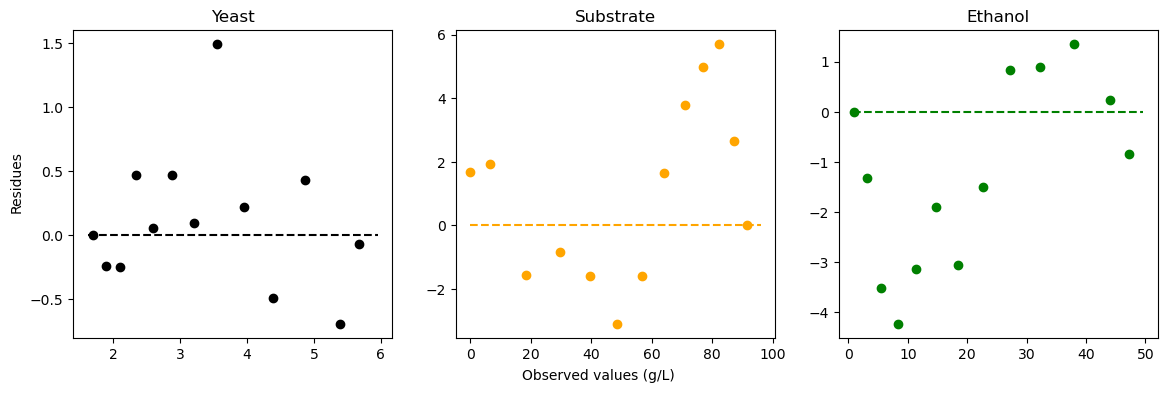

In [85]:
#Residues vs. estimated plots
plt.figure(3)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.text(0.5, 0.005, 'Observed values (g/L)', ha='center')
fig.text(0.08, 0.5, 'Residues', va='center', rotation='vertical')


axs[0].plot(Xopt,resX, 'o', color='black')
axs[0].plot([min(Xopt)*0.95, max(Xopt)*1.05], [0,0], '--', color='black')
axs[0].set_title('Yeast')

axs[1].plot(Sopt,resS, 'o', color='orange')
axs[1].plot([min(Sopt)*0.95,max(Sopt)*1.05], [0,0], '--', color='orange')
axs[1].set_title('Substrate')

axs[2].plot(Popt,resP, 'o', color='green')
axs[2].plot([min(Popt)*0.95,max(Popt)*1.05], [0,0], '--', color='green')
axs[2].set_title('Ethanol')
